# [自然语言处理入门](https://github.com/FudanNLP/nlp-beginner)

## 任务一：基于机器学习的文本分类

实现基于logistic/softmax regression的文本分类

1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1

1-gram.ipynb			 deep-neural-network.ipynb
basic-text-classification.ipynb  softmax.ipynb
data				 text-classification-rnn.ipynb


### 线性回归

In [ ]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# 读取 TSV 文件并转成 Dataset
def load_dataset(path):
  data = pd.read_csv(path, delimiter='\t', encoding='utf-8')
  return tf.data.Dataset.from_tensor_slices((data['Phrase'].values, data['Sentiment'].values))

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [ ]:
TRAIN_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1/data/train.tsv'

# 读取文件
dataset = load_dataset(TRAIN_FILE_PATH)
dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# 准备数据
data = []
label = []
for feat, targ in dataset.take(156000):
  data.append(tfds.as_numpy(feat))
  if tfds.as_numpy(targ) > 2:
    label.append(1)
  else:
    label.append(0)

In [23]:
# 划分训练集与测试集
train_dataset = tf.data.Dataset.from_tensor_slices((data[:150000], label[:150000]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[150000:], label[150000:]))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
94/94 [==============================] - 20s 93ms/step - loss: 0.6838 - accuracy: 0.7461 - val_loss: 0.6444 - val_accuracy: 0.7391
Epoch 2/5
94/94 [==============================] - 6s 62ms/step - loss: 0.6244 - accuracy: 0.7484 - val_loss: 0.6017 - val_accuracy: 0.7391
Epoch 3/5
94/94 [==============================] - 6s 64ms/step - loss: 0.5906 - accuracy: 0.7411 - val_loss: 0.5685 - val_accuracy: 0.7391
Epoch 4/5
94/94 [==============================] - 6s 63ms/step - loss: 0.5551 - accuracy: 0.7448 - val_loss: 0.5222 - val_accuracy: 0.7391
Epoch 5/5
94/94 [==============================] - 6s 65ms/step - loss: 0.4938 - accuracy: 0.7493 - val_loss: 0.4471 - val_accuracy: 0.7781


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

94/94 [==============================] - 2s 16ms/step - loss: 0.4381 - accuracy: 0.7833
Test Loss: 0.43806910514831543
Test Accuracy: 0.7833333611488342


(0.0, 0.6833128556609154)

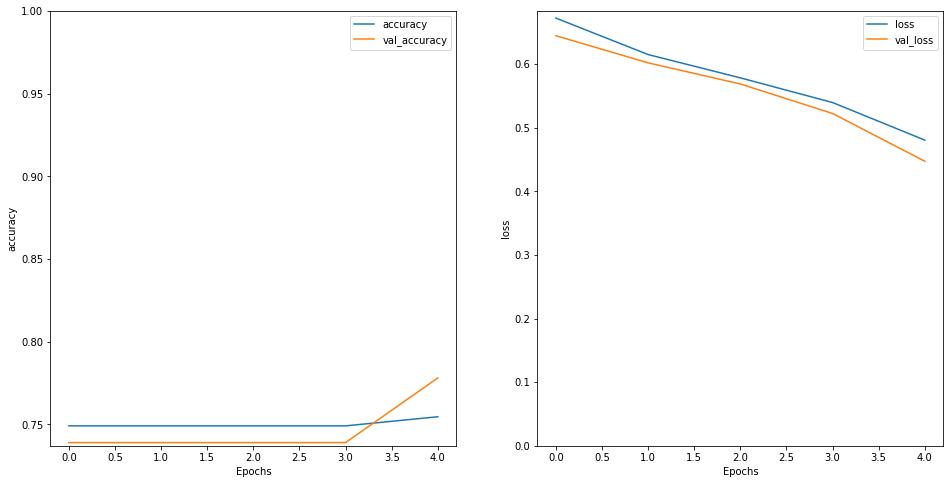

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
94/94 [==============================] - 36s 170ms/step - loss: 0.6859 - accuracy: 0.7527 - val_loss: 0.6493 - val_accuracy: 0.7391
Epoch 2/10
94/94 [==============================] - 10s 107ms/step - loss: 0.6334 - accuracy: 0.7534 - val_loss: 0.6119 - val_accuracy: 0.7391
Epoch 3/10
94/94 [==============================] - 10s 107ms/step - loss: 0.6040 - accuracy: 0.7512 - val_loss: 0.5776 - val_accuracy: 0.7391
Epoch 4/10
94/94 [==============================] - 10s 109ms/step - loss: 0.5492 - accuracy: 0.7621 - val_loss: 0.4891 - val_accuracy: 0.7417
Epoch 5/10
94/94 [==============================] - 10s 110ms/step - loss: 0.4704 - accuracy: 0.7769 - val_loss: 0.4266 - val_accuracy: 0.8026
Epoch 6/10
94/94 [==============================] - 11s 114ms/step - loss: 0.4150 - accuracy: 0.8173 - val_loss: 0.3966 - val_accuracy: 0.8198
Epoch 7/10
94/94 [==============================] - 10s 109ms/step - loss: 0.3863 - accuracy: 0.8378 - val_loss: 0.3741 - val_accuracy: 0.8313

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

94/94 [==============================] - 2s 25ms/step - loss: 0.3227 - accuracy: 0.8705
Test Loss: 0.3226718008518219
Test Accuracy: 0.8705000281333923


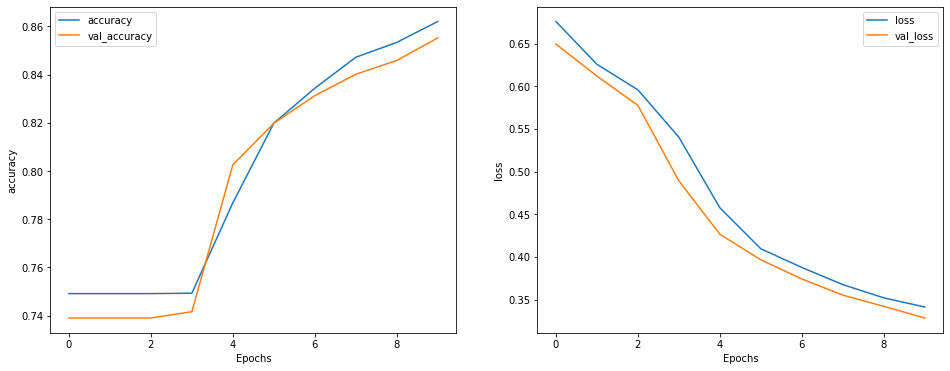

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')